In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import itertools
import random

In [3]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.uniform.Uniform(-10,10)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

In [5]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
r = enc.sample(x_fine,100)
r_all = np.asarray(list(itertools.product([0, 1], repeat=N)))
r_all = torch.tensor(r_all).transpose(0,1).type(torch.float)

In [34]:
class rate_ising(torch.nn.Module):
    def __init__(self,N):
        super().__init__()
        self.h = torch.nn.Parameter(torch.ones(N)[None,:])
        W = np.sqrt(1/N)*torch.randn(N,N)
        J = W*W.transpose(0,1)
        J.fill_diagonal_(0)
        self.J = torch.nn.Parameter(J)
    def forward(self,enc,x):
        eta = enc(x)
        mu_r_x = torch.sigmoid(eta).transpose(0,1)
        #Data dependent elemts
        eta_h_r = ((eta - self.h)*mu_r_x.transpose(0,1)).sum(dim=1)
        r_J_r = (mu_r_x*(self.J@mu_r_x)).sum(dim=0)
        #Bernoulli partition function   
        logZ1 = (torch.log( 1 + torch.exp(eta))).sum(dim=1)
        #Ising partition function
        logZ = torch.logsumexp((self.h@r_all + (r_all*(self.J@r_all)).sum(dim=0)),1)
        R = (eta_h_r - r_J_r + logZ1 + logZ).mean()
        return R

In [39]:
q = rate_ising(N)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
params = q.parameters()
lr = 1e-3
opt = torch.optim.Adam(params,lr)
lVec = []
for n in range(10000):
    loss = q(enc,x_fine)
    opt.zero_grad()
    loss.backward()
    opt.step()
    lVec.append(loss.item())


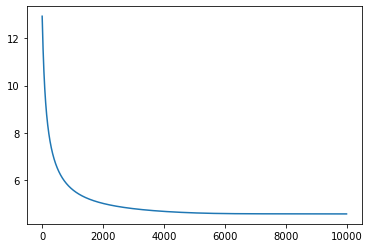

In [40]:
plt.plot(lVec)

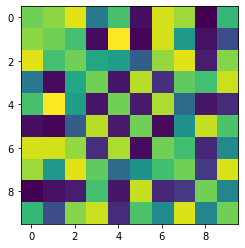

In [55]:
plt.imshow(q.J.detach(),vmin=q.J.min().item(),vmax=q.J.max().item())

In [73]:
rTA = torch.reshape(r,(-1,N)).transpose(0,1)

In [74]:
np.save('myspikes.npy',rTA.numpy())

In [62]:
r.shape

torch.Size([1000, 100, 10])